In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Bilibili_Blackroom_Spider')

In [ ]:
os.chdir('Bilibili_Blackroom_Spider')

FileNotFoundError: ignored

In [3]:
!pwd

/content/drive/My Drive/Bilibili_Blackroom_Spider


In [1]:
!lsb_release -a
!uname -r

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
4.19.112+


In [3]:
!/opt/bin/nvidia-smi

Thu Apr 29 20:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python --version

Python 3.7.10


In [3]:
import jieba
from tqdm import tqdm
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.engine.topology import Layer
from keras.layers import Embedding, Input, Dense, Conv2D, MaxPooling2D, Concatenate, Reshape, Dropout, Flatten, Lambda, LSTM, Bidirectional
from keras.models import Model
from keras import optimizers
import pdb
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from keras import backend as K
import re
import codecs
from keras import initializers, regularizers, constraints
import gc
import time
from gensim.models import Word2Vec
from keras import regularizers
import argparse
import pprint
import gensim
# from glove import Glove
# from glove import Corpus

EMBED_SIZE=200
MAX_LEN= 10 #样本最大长度为11，但是大部分长度都在0-40
EPOCHS = 25 #50
LSTM_EPOCHS = 50
BATCH_SIZE = 1024
VAL_SPLIT = 0.1 #数据量很大，验证集可以不用20%
PUCNTS = [' ', '\'', '\"', '-', '.']

D:\Anaconda3\envs\tensorflow\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [14]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

class Metrics(Callback):
    def __init__(self, test_data, test_label):
        super().__init__()
        self.test_data = test_data #记录测试集文本
        self.test_label = test_label #记录测试集标签
        
    def on_train_begin(self, logs={}):    #在训练前记录
        print("on train begin", len(self.test_data))    #输出测试集大小
        self.test_f1s = [] #记录测试集的F1参数
        self.test_recalls = []   #记录测试集的召回率
        self.test_precisions = []    #记录测试集的精确度

    def on_epoch_end(self, epoch, logs={}):   #在每一个epoch结束的时候
        print()
        print("on epoch end :", len(self.test_data))    #结束的时候输出此时测试集的大小
        data_num = len(self.test_data) ## 等于所有数据 / batchsize，所以所有数据需要能够整除

        test_pred = model.predict(self.test_data)    #测试集正确
        test_true = self.test_label
        test_pred_flat = np.zeros(data_num)    #测试集预测
        test_true_flat = np.zeros(data_num)    #测试集正确

        for data_count in range(data_num):
            test_pred_flat[data_count] = np.argmax(test_pred[data_count])
            test_true_flat[data_count] = np.argmax(test_true[data_count])
        print()
        
        _test_f1 = f1_score(test_true_flat, test_pred_flat, average='macro')
        _test_recall = recall_score(test_true_flat, test_pred_flat, average='macro')
        _test_precision = precision_score(test_true_flat, test_pred_flat, average='macro')
        self.test_f1s.append(_test_f1)
        self.test_recalls.append(_test_recall)
        self.test_precisions.append(_test_precision)
        print('— test_f1: %f — test_precision: %f — test_recall %f' %(_test_f1, _test_precision, _test_recall))
        print(' — test_f1:' ,_test_f1)
        return

In [7]:
"""Attention Layer"""
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [8]:
"LSTM models"
def model_lstm_attn(word_index, label_index, embedding_matrix):
    inp=Input(shape=(MAX_LEN,))
    x=Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix],input_length=MAX_LEN,trainable=False)(inp)
    x=Bidirectional(LSTM(128,return_sequences=True))(x)
    x=Bidirectional(LSTM(64,return_sequences=True))(x)
    x=Attention(MAX_LEN)(x)
    x=Dropout(0.2)(x)
    x=Dense(64,activation="relu")(x)
    x=Dropout(0.5)(x)
    x=Dense(len(labels_index), activation='softmax')(x)
    model=Model(inputs=inp,outputs=x)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    return model

In [9]:
"CNN Model"
def model_cnn(word_index, label_index, embedding_matrix):
    filter_sizes=[1,2,3,5]
    num_filters=36

    inp=Input(shape=(MAX_LEN,))
    x=Embedding(len(word_index)+1,EMBED_SIZE,weights=[embedding_matrix])(inp)
    x=Reshape((MAX_LEN,EMBED_SIZE,1))(x)

    maxpool_pool=[]
    for i in range(len(filter_sizes)):
        conv=Conv2D(num_filters,kernel_size=(filter_sizes[i],EMBED_SIZE),
                    kernel_initializer='he_normal',activation='relu')(x)
        dropout=Dropout(0.1)(conv)
        maxpool_pool.append(MaxPooling2D(pool_size=(MAX_LEN-filter_sizes[i]+1,1))(dropout))
        

    z=Concatenate(axis=1)(maxpool_pool)
    z=Flatten()(z)
    z=Dropout(0.5)(z)

    outp=Dense(len(labels_index), activation='softmax')(z)

    model=Model(inputs=inp,outputs=outp)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    return model

In [11]:
def clean_text(x):
    if str(x) == 'nan':
      return ''
    x = x.strip()
    for punct in PUCNTS:
        x = x.replace(punct,'')
    return x

"让文本只保留汉字、英文和数字"
def is_chinese_alphabet_number(xchar):
    if (xchar >= u'\u4e00' and xchar <= u'\u9fa5') or (xchar >= u'\u0030' and xchar <= u'\u0039') or (xchar >= u'\u0041' and xchar <= u'\u005a') or (xchar >= u'\u0061' and xchar <= u'\u007a'):
        return True
    else:
        return False
"将汉字、英文和数字保留下来"
def keep_text(x):
    out_str=''
    for i in x:
        if is_chinese_alphabet_number(i):
            out_str = out_str+i
    return out_str

def seg_sentence(sentence,stopwords):
    "对句子进行分词和去除停用词"
    jieba.load_userdict("dataset/user_dict.txt")
    sentence_lower = sentence.lower()
    sentence_seged = jieba.cut(sentence_lower, cut_all=False)
    outstr=''
    for word in sentence_seged:
        if word not in stopwords:
                outstr+=word
                outstr+=" "
    return outstr

def build_vocab(sentences,verbose=True):
    "追踪训练词汇表，遍历所有文本对单词进行计数"
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        #print(sentence)
        for word in sentence.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1

    return vocab

def texts_to_sequences(sentences,vocab,verbose=True):
    seq_sentences=[]
    #pdb.set_trace()
    unk_vec=np.random.random(embed_size)*0.5
    unk_vec=unk_vec-unk_vec.mean()
    for sentence in tqdm(sentences,disable=(not verbose)):
        seq_sentence=[]
        for word in sentence.split():
            seq_sentence.append(vocab.get(word,unk_vec))
        seq_sentences.append(seq_sentence)
    return seq_sentences

def load_and_prec():
    vocab_size = 100
    count = 0
    if not os.path.exists('dataset/pre_dataset.csv') :
        #文件读取
        dataset = pd.read_csv('dataset/dataset_long.csv',sep='\t')
        #创建停用词列表
        stopwords_file=open('dataset/stopwords/my_stopwords.txt','r',encoding='utf-8')
        my_stopwords=stopwords_file.readlines()
        stopwords=[]
        for item in my_stopwords:stopwords.append(item.replace('\n',''))
        # stopwords = ['的', '呀', '这', '那', '就', '的话', '如果', '了', '建议', '说','是', '吧','我','你','在','这个','被','啊','和','吗','觉得','就是','应该','认为','很','感觉','可能','会','下面']
        #创建自定义词表
        dataset["content"]=dataset["content"].apply(lambda x: clean_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: keep_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: seg_sentence(x, stopwords))
        dataset.to_csv('dataset/pre_dataset.csv', index = False)
    else:
        # dataset = pd.read_csv('dataset/dataset.txt',sep='\t',names=['content','vote'])
        dataset = pd.read_csv('dataset/pre_dataset.csv')
        for item in dataset['content']:
            if str(item) == 'nan':
                dataset['content'][count] = ''
            count += 1
            
    labels = dataset['vote'].values
    texts = dataset['content'].values
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index)) #Found 39468 unique tokens.词频词典
    
    word_num = [len(text) for text in sequences]
    plt.figure(figsize=(8,5))
    _ = plt.hist(word_num, bins = 100)
    plt.xlabel('word number')
    plt.ylabel('Freq')
    plt.show()

    data = pad_sequences(sequences, maxlen=MAX_LEN, padding = 'post') 
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape) #(120000, 40)
    print('Shape of label tensor:', labels.shape) #(120000, 3)
    
    x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size = VAL_SPLIT, random_state = 2021)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = VAL_SPLIT, random_state = 2021)
    
    print("Train shape: ",x_train.shape)   # (97200, 40)
    print("Val shape: ",x_val.shape)   # (10800, 40)
    print("Test shape: ",x_test.shape) # (12000, 40)
    
    np.random.seed(2021)
    trn_idx=np.random.permutation(len(x_train))
    val_idx=np.random.permutation(len(x_val))
    print(x_train[0])
    x_train=x_train[trn_idx]
    x_val=x_val[val_idx]
    y_train=y_train[trn_idx]
    y_val=y_val[val_idx]
    print(x_train[0])
    return dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer

def input_embed(verbose=True):
    embeddings_index = {}
    with open('dataset/1000000-small.txt','r') as f:
        for i,line in tqdm(enumerate(f),disable=(not verbose)):
            if i == 0:
                continue
            values = line.split()
            word = values[0]
            codes = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = codes
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

def embed_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
            

Found 31515 unique tokens.


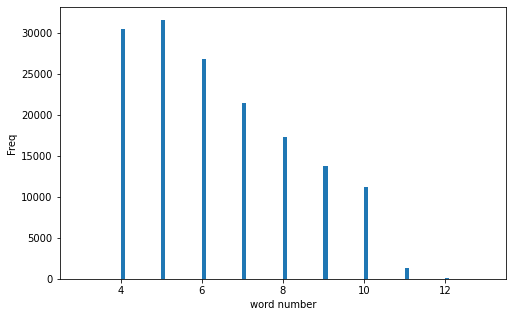

Shape of data tensor: (154061, 10)
Shape of label tensor: (154061, 3)
Train shape:  (124788, 10)
Val shape:  (13866, 10)
Test shape:  (15407, 10)
[347 734 229 233   0   0   0   0   0   0]
[ 387 3955 2815 1503  129   85 1060    0    0    0]


1000001it [01:14, 13359.16it/s]


Found 1000000 word vectors.


In [12]:
dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer = load_and_prec()
np.save("dataset/x_train.npy",x_train)
np.save("dataset/x_val.npy",x_val)
np.save("dataset/x_test.npy",x_test)
np.save("dataset/y_train.npy",y_train)
np.save("dataset/y_val.npy",y_val)
np.save("dataset/y_test.npy",y_test)
# saving 
with open('dataset/tokenizer.pickle', 'wb') as handle: 
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 

embeddings_index = input_embed()
embedding_matrix = embed_matrix(tokenizer.word_index, embeddings_index)
np.save("dataset/embedding_matrix.npy",embedding_matrix)

In [13]:
# if __name__ == '__main__':
x_train = np.load("dataset/x_train.npy")
x_val = np.load("dataset/x_val.npy")
x_test = np.load("dataset/x_test.npy")
y_train = np.load("dataset/y_train.npy")
y_val = np.load("dataset/y_val.npy")
y_test = np.load("dataset/y_test.npy")
with open('dataset/tokenizer.pickle', 'rb') as handle: 
  tokenizer = pickle.load(handle)
embedding_matrix = np.load('dataset/embedding_matrix.npy')
labels_index = [0, 1, 2]

In [18]:
K.clear_session()
model = model_cnn(tokenizer.word_index, labels_index, embedding_matrix)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 200)      6303200     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10, 200, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 1, 36)    7236        reshape[0][0]                    
______________________________________________________________________________________________

In [20]:
myMetrics = Metrics(x_test, y_test)   #测试集在每个epoch的表现
history = model.fit(x_train, y_train, callbacks = [myMetrics], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

on train begin 15407
Epoch 1/25
122/122 [==============================] - 13s 97ms/step - loss: 1.1490 - accuracy: 0.4299 - val_loss: 0.7438 - val_accuracy: 0.7206

on epoch end : 15407

— test_f1: 0.722339 — test_precision: 0.733735 — test_recall 0.723795
 — test_f1: 0.7223390058774651
Epoch 2/25
122/122 [==============================] - 12s 97ms/step - loss: 0.7584 - accuracy: 0.6752 - val_loss: 0.6343 - val_accuracy: 0.7515

on epoch end : 15407

— test_f1: 0.753104 — test_precision: 0.763273 — test_recall 0.754626
 — test_f1: 0.7531041022499858
Epoch 3/25
122/122 [==============================] - 12s 96ms/step - loss: 0.6507 - accuracy: 0.7278 - val_loss: 0.5842 - val_accuracy: 0.7648

on epoch end : 15407

— test_f1: 0.767217 — test_precision: 0.773554 — test_recall 0.769243
 — test_f1: 0.7672170195720497
Epoch 4/25
122/122 [==============================] - 12s 95ms/step - loss: 0.5997 - accuracy: 0.7523 - val_loss: 0.5543 - val_accuracy: 0.7761

on epoch end : 15407

— test_f

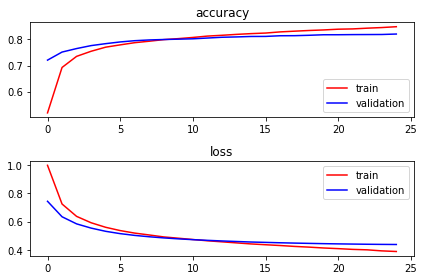

482/482 [==============================] - 2s 4ms/step - loss: 0.4315 - accuracy: 0.8210
Test loss: 0.432, accuracy: 0.821


In [21]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

In [22]:
test_acc=[0.732739,0.761237,0.772923,0.782319,0.780237,0.793846,0.795838,0.792389,0.799237,0.801458,0.803983,0.805739,0.810123,0.809328,0.810273,0.811237,0.815283,0.815293,0.816238,0.818236,0.818984,0.819105,0.817235,0.820178,0.821059,]

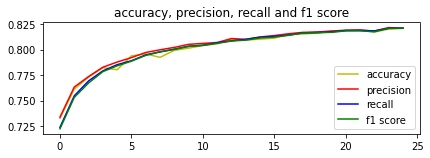

In [24]:
# plot loss function
plt.subplot(211)
plt.title("accuracy, precision, recall and f1 score")
plt.plot(myMetrics.test_acc, color="y", label="accuracy")
plt.plot(myMetrics.test_precisions, color="r", label="precision")
plt.plot(myMetrics.test_recalls, color="b", label="recall")
plt.plot(myMetrics.test_f1s, color="g", label="f1 score")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [10]:
model_save_path = "dataset/models/CNNmodel_94261604.h5"
# 保存模型
# model.save(model_save_path)
# 删除当前已存在的模型
# del model
# 加载模型
from keras.models import load_model
model = load_model(model_save_path)

In [11]:
classes=['break', 'rule', 'delete']
filename1 = "dataset/LSTM_confusion_matrix_1.jpg"
filename2 = "dataset/LSTM_confusion_matrix_2.jpg"

In [12]:
import itertools
def paintConfusionMatrix(cfmatrix, classes, filename):
    plt.figure(figsize=(15,10))   #大小
    plt.imshow(cfmatrix,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('confusion matrix')

    tick_marks=np.arange(len(classes))    
    plt.xticks(tick_marks,classes,rotation=90,size=18)
    plt.yticks(tick_marks,classes,size=18)
    # plt.xaxis.tick_top()
    plt.xlabel('Pred label',size=20)
    plt.ylabel('True label',size=20)
    fmt='.2f' 
    thresh=cfmatrix.max()/2.
    for i,j in itertools.product(range(cfmatrix.shape[0]),range(cfmatrix.shape[1])):
        plt.text(j, i, format(cfmatrix[i, j], fmt), horizontalalignment="center", color="white" if cfmatrix[i, j] > thresh else "black",size = 22)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

— 1068_f1: 0.721911 — 1068_precision: 0.734740 — 1068_recall 0.745829 — 1068_accuracy 0.722222
the total number of test data is 504


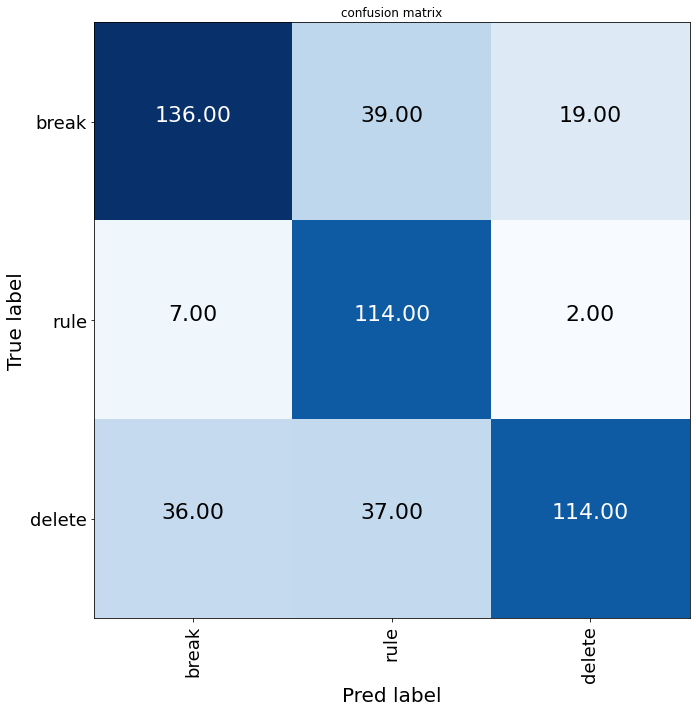

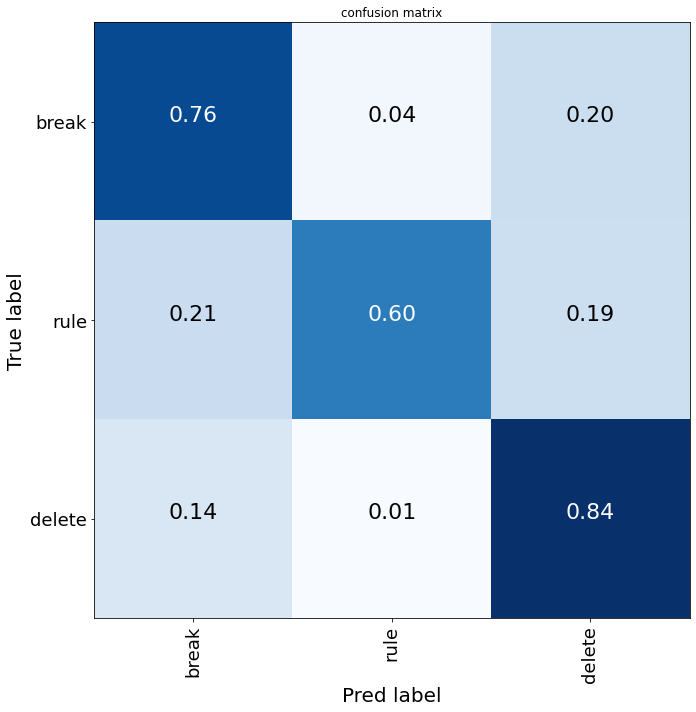

In [20]:
from sklearn.metrics import confusion_matrix

data_num = len(x) ## 等于所有数据 / batchsize，所以所有数据需要能够整除
test_pred = model.predict(x)    #验证集正确
test_true = y
test_pred_flat = np.zeros(data_num)    #验证集预测
test_true_flat = np.zeros(data_num)    #验证集正确
for data_count in range(data_num):
    test_pred_flat[data_count] = np.argmax(test_pred[data_count])
    test_true_flat[data_count] = np.argmax(test_true[data_count])
test_accuracy = accuracy_score(test_true_flat, test_pred_flat)
test_f1 = f1_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
test_recall = recall_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
test_precision = precision_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
print('— 1068_f1: %f — 1068_precision: %f — 1068_recall %f — 1068_accuracy %f' %(test_f1, test_precision, test_recall, test_accuracy))

conf_matrix_1 = [[0,0,0],[0,0,0],[0,0,0]]
print('the total number of test data is %d' %data_num)
conf_matrix_1 = confusion_matrix(test_true_flat, test_pred_flat)#.ravel()
# conf_matrix_1[0][0] = tp.item()
# conf_matrix_1[0][1] = fn.item()
# conf_matrix_1[1][0] = fp.item()
# conf_matrix_1[1][1] = tn.item()
conf_matrix_1 = np.asarray(conf_matrix_1)
paintConfusionMatrix(conf_matrix_1, classes, filename1)
conf_matrix_2 = [[0,0,0],[0,0,0],[0,0,0]]
bb, br, bd, rb, rr, rd, db, dr, dd = 0, 0, 0, 0, 0, 0, 0, 0, 0
b_num, r_num, d_num = 0, 0, 0
for data_count in range(data_num):
    if test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 0:
      bb += 1
      b_num += 1
    elif test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 1:
      br += 1
      b_num += 1
    elif test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 2:
      bd += 1
      b_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 0:
      rb += 1
      r_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 1:
      rr += 1
      r_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 2:
      rd += 1
      r_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 0:
      db += 1
      d_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 1:
      dr += 1
      d_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 2:
      dd += 1
      d_num += 1

bb, br, bd, rb, rr, rd, db, dr, dd = bb / b_num, br / b_num, bd / b_num, rb / r_num, rr / r_num, rd / r_num, db / d_num, dr / d_num, dd / d_num
#pdb.set_trace()
conf_matrix_2[0][0] = bb
conf_matrix_2[0][1] = br
conf_matrix_2[0][2] = bd
conf_matrix_2[1][0] = rb
conf_matrix_2[1][1] = rr
conf_matrix_2[1][2] = rd
conf_matrix_2[2][0] = db
conf_matrix_2[2][1] = dr
conf_matrix_2[2][2] = dd
conf_matrix_2 = np.asarray(conf_matrix_2)
paintConfusionMatrix(conf_matrix_2, classes, filename2)

In [41]:
K.clear_session()
model = model_lstm_attn(tokenizer.word_index, labels_index, embedding_matrix)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 200)           6303200   
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 128)           164352    
_________________________________________________________________
attention (Attention)        (None, 128)               138       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256  

In [ ]:
myMetrics = Metrics(x_test, y_test)   #测试集在每个epoch的表现
history = model.fit(x_train, y_train, callbacks = [myMetrics], epochs=LSTM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

on train begin 15407
Epoch 1/50
122/122 [==============================] - 9s 29ms/step - loss: 1.0165 - accuracy: 0.5075 - val_loss: 0.6409 - val_accuracy: 0.7375

on epoch end : 15407

— test_f1: 0.742489 — test_precision: 0.749232 — test_recall 0.744939
 — test_f1: 0.7424885973120757
Epoch 2/50
122/122 [==============================] - 2s 18ms/step - loss: 0.6367 - accuracy: 0.7473 - val_loss: 0.5570 - val_accuracy: 0.7698

on epoch end : 15407

— test_f1: 0.771888 — test_precision: 0.776948 — test_recall 0.773008
 — test_f1: 0.7718877169286408
Epoch 3/50
122/122 [==============================] - 2s 18ms/step - loss: 0.5661 - accuracy: 0.7709 - val_loss: 0.5345 - val_accuracy: 0.7772

on epoch end : 15407

— test_f1: 0.782695 — test_precision: 0.784130 — test_recall 0.783688
 — test_f1: 0.7826953886960283
Epoch 4/50
122/122 [==============================] - 2s 18ms/step - loss: 0.5483 - accuracy: 0.7764 - val_loss: 0.5220 - val_accuracy: 0.7830

on epoch end : 15407

— test_f1: 0

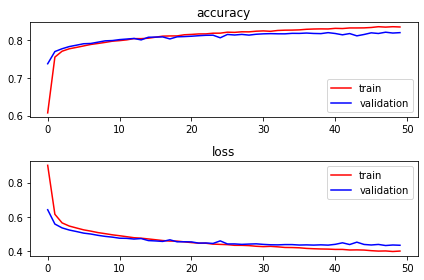

482/482 [==============================] - 2s 4ms/step - loss: 0.4287 - accuracy: 0.8225
Test loss: 0.429, accuracy: 0.823


In [ ]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

In [1]:
test_accuracy=[0.752378,0.772394,0.783463,0.7885490,0.790237,0.793489,0.796238,0.798346,0.802394,0.801298,
        0.803728,0.805238,0.808239,0.807462,0.810282,0.811367,0.813368,0.811782,0.814023,0.814782,
        0.814292,0.815383,0.815392,0.814920,0.815023,0.818923,0.818736,0.817263,0.817293,0.819220,
        0.819263,0.819357,0.820011,0.822839,0.821027,0.820136,0.821358,0.821923,0.823910,0.822782,
        0.821307,0.821289,0.822038,0.822302,0.823729,0.821023,0.823782,0.823843,0.824393,0.823973]
test_precision=[0.749232,0.776948,0.784130,0.788434,0.791180,0.794655,0.797367,0.800379,0.801263,0.802613,
        0.804272,0.806656,0.809389,0.808633,0.810457,0.812960,0.814195,0.812210,0.816599,0.815374,
        0.815104,0.816178,0.816326,0.816568,0.815611,0.819116,0.818575,0.818133,0.818750,0.819641,
        0.819554,0.820747,0.821459,0.820060,0.821225,0.821524,0.821307,0.821134,0.820151,0.823539,
        0.821904,0.821439,0.822259,0.822537,0.822960,0.822994,0.823828,0.824684,0.823462,0.823135]
test_recall=[0.744939,0.773008,0.783688,0.786836,0.787349,0.793018,0.793229,0.796765,0.799823,0.800981,
      0.802184,0.804024,0.803931,0.808168,0.807410,0.806776,0.809976,0.802226,0.809867,0.809938,
      0.810410,0.813698,0.812149,0.814572,0.814907,0.816169,0.818570,0.816281,0.819855,0.812349,
      0.819014,0.817245,0.818283,0.815401,0.815913,0.823144,0.821364,0.821207,0.819527,0.820415,
      0.822115,0.822676,0.821267,0.804023,0.817056,0.818747,0.817667,0.822559,0.824167,0.822418]
test_f1=[0.742489,0.771888,0.782695,0.785629,0.788390,0.792835,0.792059,0.796699,0.799816,0.801171,
    0.802079,0.803532,0.805192,0.805663,0.807231,0.807631,0.810561,0.805095,0.810970,0.811804,
    0.812013,0.813209,0.812814,0.815188,0.811328,0.816619,0.817903,0.815897,0.818625,0.814256,
    0.817781,0.817397,0.818245,0.816339,0.816351,0.822035,0.820034,0.820823,0.818486,0.819836,
    0.819970,0.820013,0.820459,0.807437,0.819151,0.820132,0.819504,0.822292,0.822657,0.821966]

In [ ]:
test_accuracy=[0.752378,0.772394,0.783463,0.7885490,0.790237,0.793489,0.796238,0.798346,0.802394,0.801298,
        0.803728,0.805238,0.808239,0.807462,0.810282,0.811367,0.813368,0.811782,0.814023,0.814782,
        0.814292,0.815383,0.815392,0.814920,0.815023,0.818923,0.818736,0.817263,0.817293,0.819220,
        0.819263,0.819357,0.820011,0.822839,0.821027,0.820136,0.821358,0.821923,0.823910,0.822782,
        0.821307,0.821289,0.822038,0.822302,0.823729,0.821023,0.823782,0.823843,0.824393,0.823973]
test_precision=[0.749232,0.776948,0.784130,0.788434,0.791180,0.794655,0.797367,0.800379,0.801263,0.802613,
        0.804272,0.806656,0.809389,0.808633,0.810457,0.812960,0.814195,0.812210,0.816599,0.815374,
        0.815104,0.816178,0.816326,0.816568,0.815611,0.819116,0.818575,0.818133,0.818750,0.819641,
        0.819554,0.820747,0.821459,0.820060,0.821225,0.821524,0.821307,0.821134,0.820151,0.823539,
        0.821904,0.821439,0.822259,0.822537,0.822960,0.822994,0.823828,0.824684,0.823462,0.823135]
test_recall=[0.744939,0.773008,0.783688,0.786836,0.787349,0.793018,0.793229,0.796765,0.799823,0.800981,
      0.802184,0.804024,0.803931,0.808168,0.807410,0.806776,0.809976,0.802226,0.809867,0.809938,
      0.810410,0.813698,0.812149,0.814572,0.814907,0.816169,0.818570,0.816281,0.819855,0.812349,
      0.819014,0.817245,0.818283,0.815401,0.815913,0.823144,0.821364,0.821207,0.819527,0.820415,
      0.822115,0.822676,0.821267,0.804023,0.817056,0.818747,0.817667,0.822559,0.824167,0.822418]
test_f1=[0.742489,0.771888,0.782695,0.785629,0.788390,0.792835,0.792059,0.796699,0.799816,0.801171,
    0.802079,0.803532,0.805192,0.805663,0.807231,0.807631,0.810561,0.805095,0.810970,0.811804,
    0.812013,0.813209,0.812814,0.815188,0.811328,0.816619,0.817903,0.815897,0.818625,0.814256,
    0.817781,0.817397,0.818245,0.816339,0.816351,0.822035,0.820034,0.820823,0.818486,0.819836,
    0.819970,0.820013,0.820459,0.807437,0.819151,0.820132,0.819504,0.822292,0.822657,0.821966]

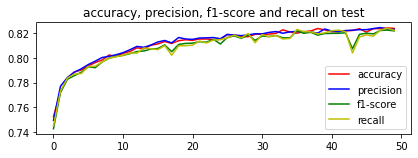

In [5]:
# plot loss function
plt.subplot(211)
plt.title("accuracy, precision, f1-score and recall on test")
plt.plot(test_accuracy, color="r", label="accuracy")
plt.plot(test_precision, color="b", label="precision")
plt.plot(test_f1, color="g", label="f1-score")
plt.plot(test_recall, color="y", label="recall")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [43]:
model_save_path = "dataset/models/LSTMmodel_94261641.h5"
# 保存模型
# model.save_weights(model_save_path)
# 删除当前已存在的模型
# del model
# 加载模型
# from keras.models import load_weights
model.load_weights(model_save_path)

— test_f1: 0.821966 — test_precision: 0.823135 — test_recall 0.822418 — test_accuracy 0.822548
the total number of test data is 15407


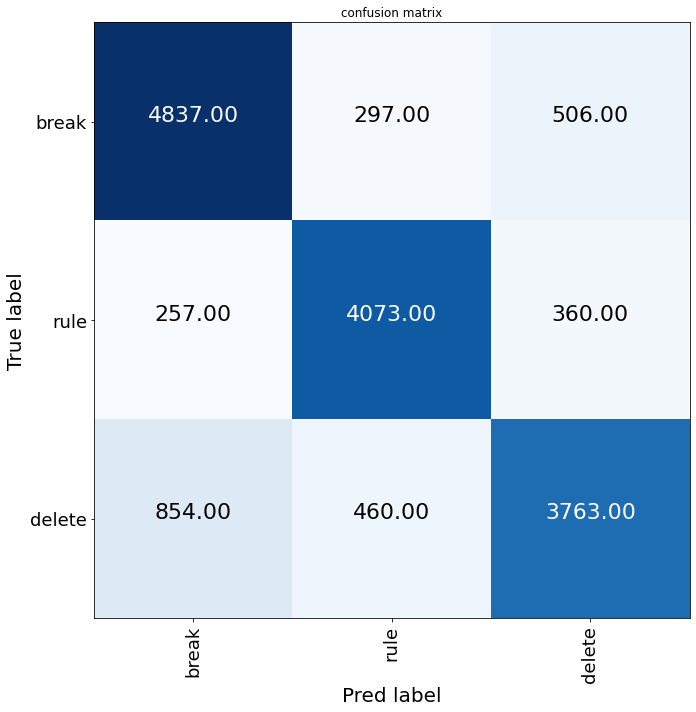

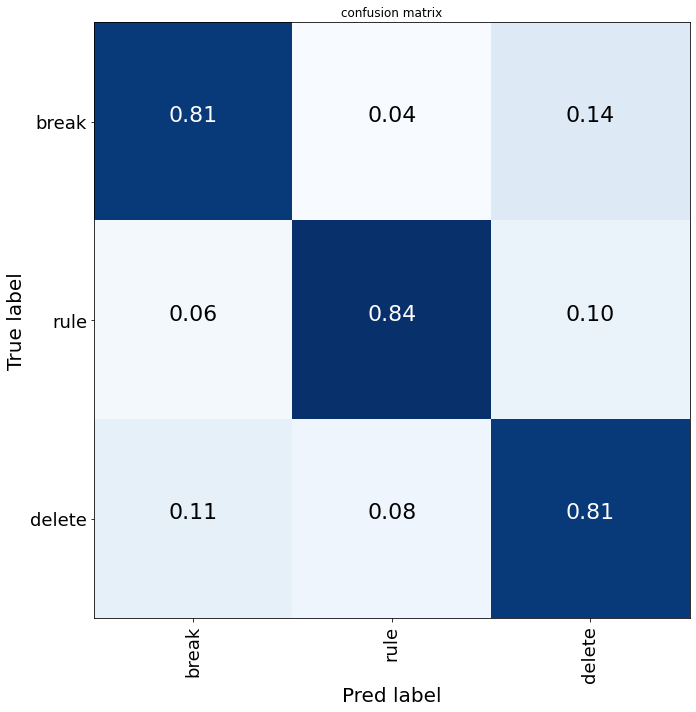

In [44]:
from sklearn.metrics import confusion_matrix

data_num = len(x_test) ## 等于所有数据 / batchsize，所以所有数据需要能够整除
test_pred = model.predict(x_test)    #验证集正确
test_true = y_test
test_pred_flat = np.zeros(data_num)    #验证集预测
test_true_flat = np.zeros(data_num)    #验证集正确
for data_count in range(data_num):
    test_pred_flat[data_count] = np.argmax(test_pred[data_count])
    test_true_flat[data_count] = np.argmax(y_test[data_count])
test_accuracy = accuracy_score(test_true_flat, test_pred_flat)
test_f1 = f1_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
test_recall = recall_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
test_precision = precision_score(test_true_flat, test_pred_flat, average='macro')  #3个数值
print('— test_f1: %f — test_precision: %f — test_recall %f — test_accuracy %f' %(test_f1, test_precision, test_recall, test_accuracy))

conf_matrix_1 = [[0,0,0],[0,0,0],[0,0,0]]
print('the total number of test data is %d' %data_num)
conf_matrix_1 = confusion_matrix(test_true_flat, test_pred_flat)#.ravel()
# conf_matrix_1[0][0] = tp.item()
# conf_matrix_1[0][1] = fn.item()
# conf_matrix_1[1][0] = fp.item()
# conf_matrix_1[1][1] = tn.item()
conf_matrix_1 = np.asarray(conf_matrix_1)
paintConfusionMatrix(conf_matrix_1, classes, filename1)
conf_matrix_2 = [[0,0,0],[0,0,0],[0,0,0]]
bb, br, bd, rb, rr, rd, db, dr, dd = 0, 0, 0, 0, 0, 0, 0, 0, 0
b_num, r_num, d_num = 0, 0, 0
for data_count in range(data_num):
    if test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 0:
      bb += 1
      b_num += 1
    elif test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 1:
      br += 1
      b_num += 1
    elif test_pred_flat[data_count] == 0 and test_true_flat[data_count] == 2:
      bd += 1
      b_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 0:
      rb += 1
      r_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 1:
      rr += 1
      r_num += 1
    elif test_pred_flat[data_count] == 1 and test_true_flat[data_count] == 2:
      rd += 1
      r_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 0:
      db += 1
      d_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 1:
      dr += 1
      d_num += 1
    elif test_pred_flat[data_count] == 2 and test_true_flat[data_count] == 2:
      dd += 1
      d_num += 1

bb, br, bd, rb, rr, rd, db, dr, dd = bb / b_num, br / b_num, bd / b_num, rb / r_num, rr / r_num, rd / r_num, db / d_num, dr / d_num, dd / d_num
#pdb.set_trace()
conf_matrix_2[0][0] = bb
conf_matrix_2[0][1] = br
conf_matrix_2[0][2] = bd
conf_matrix_2[1][0] = rb
conf_matrix_2[1][1] = rr
conf_matrix_2[1][2] = rd
conf_matrix_2[2][0] = db
conf_matrix_2[2][1] = dr
conf_matrix_2[2][2] = dd
conf_matrix_2 = np.asarray(conf_matrix_2)
paintConfusionMatrix(conf_matrix_2, classes, filename2)

In [ ]:
from keras.models import load_model
model_save_path = "dataset/models/CNNmodel_94261604.h5"
model = load_model(model_save_path)
data_num = len(x_train)
train_pred = model.predict(x_train)    #测试集正确
train_true = y_train
train_pred_flat = np.zeros(data_num)    #测试集预测
train_true_flat = np.zeros(data_num)    #测试集正确
index=np.zeros(data_num)
for data_count in range(data_num):
  train_pred_flat[data_count] = np.argmax(train_pred[data_count])
  train_true_flat[data_count] = np.argmax(train_true[data_count])

        
_train_f1 = f1_score(train_true_flat, train_pred_flat, average='macro')
_train_recall = recall_score(train_true_flat, train_pred_flat, average='macro')
_train_precision = precision_score(train_true_flat, train_pred_flat, average='macro')
print('— train_f1: %f — train_precision: %f — train_recall %f' %(_train_f1, _train_precision, _train_recall))
print(' — train_f1:' ,_train_f1)

— train_f1: 0.862640 — train_precision: 0.864254 — train_recall 0.862301
 — train_f1: 0.8626398468293367


In [ ]:
data_num = len(x_test)
test_pred = model.predict(x_test)    #测试集正确
test_true = y_test
test_pred_flat = np.zeros(data_num)    #测试集预测
test_true_flat = np.zeros(data_num)    #测试集正确
index=np.zeros(data_num)
for data_count in range(data_num):
  test_pred_flat[data_count] = np.argmax(test_pred[data_count])
  test_true_flat[data_count] = np.argmax(test_true[data_count])

        
_test_f1 = f1_score(test_true_flat, test_pred_flat, average='macro')
_test_recall = recall_score(test_true_flat, test_pred_flat, average='macro')
_test_precision = precision_score(test_true_flat, test_pred_flat, average='macro')
print('— test_f1: %f — test_precision: %f — test_recall %f' %(_test_f1, _test_precision, _test_recall))
print(' — test_f1:' ,_test_f1)

— test_f1: 0.823926 — test_precision: 0.825852 — test_recall 0.823772
 — test_f1: 0.8239256344015965


In [ ]:
data_num = len(x_val)
val_pred = model.predict(x_val)    #测试集正确
val_true = y_val
val_pred_flat = np.zeros(data_num)    #测试集预测
val_true_flat = np.zeros(data_num)    #测试集正确
index=np.zeros(data_num)
for data_count in range(data_num):
  val_pred_flat[data_count] = np.argmax(val_pred[data_count])
  val_true_flat[data_count] = np.argmax(val_true[data_count])

        
_val_f1 = f1_score(val_true_flat, val_pred_flat, average='macro')
_val_recall = recall_score(val_true_flat, val_pred_flat, average='macro')
_val_precision = precision_score(val_true_flat, val_pred_flat, average='macro')
print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
print(' — val_f1:' ,_val_f1)

— val_f1: 0.816768 — val_precision: 0.819736 — val_recall 0.815940
 — val_f1: 0.8167677730222543


In [ ]:
with open ('dataset/pred_true/val_pred.txt','w') as f4:
  for pred in val_pred_flat:
    f4.write(str(pred))
    f4.write('\n')
f4.close()

In [ ]:
with open ('dataset/pred_true/val_true.txt','w') as f4:
  for pred in val_true_flat:
    f4.write(str(pred))
    f4.write('\n')
f4.close()

In [ ]:
val_diff_index=[]
count=0
for count in range(0,len(val_pred_flat)):
  if val_pred_flat[count] != val_true_flat[count]:val_diff_index.append(count)
with open ('dataset/pred_true/val_diff_index.txt','w') as f4:
  for pred in val_diff_index:
    f4.write(str(pred))
    f4.write('\n')
f4.close()

In [ ]:
if __name__ == '__main__':
  # pdb.set_trace()
  x_test_upand_5=[]
  y_test_upand_5=[]
  test_index=[]
  num=0
  num_upand_5=0
  for sentence_num in x_test:
    sent_rev=sentence_num[::-1]
    count=0
    for i in sent_rev:
      if i == 0:
        count+=1
      else:
        break
    if count <= 5:
      test_index.append(num)
      x_test_upand_5.append(x_test[num])
      y_test_upand_5.append(y_test[num])
      num_upand_5+=1
    num+=1
  print(num_upand_5)
  test_index=np.array(test_index)
  x_test_upand_5=np.array(x_test_upand_5)
  y_test_upand_5=np.array(y_test_upand_5)
  np.save("dataset/pred_true/x_test_upand_5.npy",x_test_upand_5)
  np.save("dataset/pred_true/y_test_upand_5.npy",y_test_upand_5)
  np.save("dataset/pred_true/test_upand_5_index.npy",test_index)

12306


In [ ]:
def huifu(x,y,word_index):
    train_dataset=[]
    count0=0
    count1=0
    count2=0
    countother=0
#     pdb.set_trace()
    count=0
    num=x.shape[0]
    for count in tqdm(range(0,num),disable=False):
        sentence=''
        for column in x[count]:
            if column == 0:
                sentence+=''
                continue
            sentence += get_dict_key(tokenizer.word_index, column)
            sentence += ' '
        sentence=sentence.rstrip()
        sentence+='\t'+str(np.argmax(y[count]))
        train_dataset.append(sentence)
    return train_dataset

# 根据字典的值value获得该值对应的key
def get_dict_key(dic, value):
    keys = list(dic.keys())
    values = list(dic.values())
    idx = values.index(value)
    key = keys[idx]
 
    return key

In [ ]:
dataset_list=huifu(x_test_upand_5,y_test_upand_5,tokenizer.word_index)
with open ('dataset/pred_true/test_dataset_upand_5_1.txt','w') as f4:
    for pred in dataset_list:
        f4.write(pred)
        f4.write('\n')
f4.close()

100%|██████████| 12306/12306 [03:08<00:00, 65.41it/s]


In [ ]:
f=open('dataset/pred_true/train_dataset.txt','r',encoding='utf-8')
dataset=f.readlines()
dataset_upand_5=[]
for item in train_index:
    dataset_upand_5.append(dataset[item])
with open ('dataset/pred_true/train_dataset_upand_5_1.txt','w') as f4:
    for pred in dataset_upand_5:
        f4.write(pred)
f4.close()

In [ ]:
f=open('dataset/pred_true/train_dataset.txt','r',encoding='utf-8')
dataset=f.readlines()
dataset_upand_5=[]
for item in train_index:
    dataset_upand_5.append(dataset[item])
with open ('dataset/pred_true/train_dataset_upand_5_1.txt','w') as f4:
    for pred in dataset_upand_5:
        f4.write(pred)
f4.close()

In [ ]:
dataset_list=huifu(x_test,y_test,tokenizer.word_index)
with open ('dataset/pred_true/test_dataset.txt','w') as f4:
    for pred in dataset_list:
        f4.write(pred)
        f4.write('\n')
f4.close()

100%|██████████| 15407/15407 [03:31<00:00, 72.87it/s]


In [ ]:
f=open('dataset/pred_true/train_dataset.txt','r',encoding='utf-8')
dataset=f.readlines()
f1=open('dataset/pred_true/train_diff_index.txt','r',encoding='utf-8')
train_index=f1.readlines()
count=0
for item in train_index:
    train_index[count]=int(train_index[count])
    count+=1
train_index_1=np.load('dataset/pred_true/train_upand_5_index.npy','r')


dataset_upand_5=[]

for item in tqdm(train_index_1,disable=False):
    if item not in train_index:
        dataset_upand_5.append(dataset[item])
                           
with open ('dataset/pred_true/train.txt','w') as f4:
    for pred in dataset_upand_5:
        f4.write(pred)
f4.close()

100%|██████████| 100079/100079 [04:01<00:00, 414.71it/s]


In [ ]:
vocab_size = 100
count = 0
dataset = pd.read_csv('dataset/pre_dataset.csv')
    for item in dataset['content']:
            if str(item) == 'nan':
                dataset['content'][count] = ''
            count += 1
            
    labels = dataset['vote'].values
    texts = dataset['content'].values
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index)) #Found 39468 unique tokens.词频词典
    
    word_num = [len(text) for text in sequences]
    plt.figure(figsize=(8,5))
    _ = plt.hist(word_num, bins = 100)
    plt.xlabel('word number')
    plt.ylabel('Freq')
    plt.show()

    data = pad_sequences(sequences, maxlen=MAX_LEN, padding = 'post') 
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape) #(120000, 40)
    print('Shape of label tensor:', labels.shape) #(120000, 3)
    
    x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size = VAL_SPLIT, random_state = 2021)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = VAL_SPLIT, random_state = 2021)
    
    print("Train shape: ",x_train.shape)   # (97200, 40)
    print("Val shape: ",x_val.shape)   # (10800, 40)
    print("Test shape: ",x_test.shape) # (12000, 40)
    
    np.random.seed(2021)
    trn_idx=np.random.permutation(len(x_train))
    val_idx=np.random.permutation(len(x_val))
    print(x_train[0])
    x_train=x_train[trn_idx]
    x_val=x_val[val_idx]
    y_train=y_train[trn_idx]
    y_val=y_val[val_idx]
    print(x_train[0])
    return dataset, x_train, x_val, x_test, y_train, y_val, y_test, tokenizer

In [ ]:
reader=open('dataset/dataset.txt','r',encoding='utf-8')
all_dataset=reader.readlines()

In [ ]:
train_dataset=pd.read_csv('dataset/dataset.txt',sep='\t')
pre_dataset=pd.read_csv('dataset/pre_dataset.csv')
dataset=pd.read_csv('dataset/dataset_long.csv',sep='\t')

In [ ]:
dataset1=[]
count=0
for text in tqdm(dataset['content'],disable=False):
  if(str(text)=='nan'):dataset1.append(''+'\t'+str(dataset['vote'][count]))
  else:dataset1.append(text.rstrip().lstrip()+'\t'+str(dataset['vote'][count]))
  count += 1
print(count)
print(dataset1[0])
dataset2=[]
count=0
for text in tqdm(pre_dataset['content'],disable=False):
  if(str(text)=='nan'):dataset2.append('')
  dataset2.append(text.rstrip().lstrip())
  count += 1
print(count)
print(dataset2[0])







  0%|          | 0/154061 [00:00<?, ?it/s]





  8%|▊         | 12716/154061 [00:00<00:01, 127153.15it/s]





 16%|█▌        | 24666/154061 [00:00<00:01, 124753.74it/s]





 24%|██▍       | 37097/154061 [00:00<00:00, 124619.61it/s]





 32%|███▏      | 49358/154061 [00:00<00:00, 124008.62it/s]





 40%|████      | 62320/154061 [00:00<00:00, 125638.82it/s]





 49%|████▊     | 74888/154061 [00:00<00:00, 125650.94it/s]





 56%|█████▋    | 86778/154061 [00:00<00:00, 123543.97it/s]





 64%|██████▍   | 99145/154061 [00:00<00:00, 123581.35it/s]





 73%|███████▎  | 111808/154061 [00:00<00:00, 124478.97it/s]





 80%|████████  | 123751/154061 [00:01<00:00, 121126.26it/s]





 88%|████████▊ | 136332/154061 [00:01<00:00, 122491.82it/s]





100%|██████████| 154061/154061 [00:01<00:00, 123322.19it/s]






  0%|          | 0/154061 [00:00<?, ?it/s]





100%|██████████| 154061/154061 [00:00<00:00, 944378.44it/s]

154061
这个梗对于真人来讲已经是性骚扰了，建议封禁	0
154061
梗 对于 真人 来讲 已经 性骚扰 封禁


In [ ]:
np_dataset2=np.array(dataset2)

In [ ]:
data_long=[]
count1=0
for item in all_dataset:
  count=0
  for line in dataset2:
    length=len(item.split('\t')[0])
    length1=len(line)
    if item.split('\t')[0]==line[length1-length:length1]:
      # if count1==0:pdb.set_trace()
      data_long.append(dataset1[count])
    count+=1
  count1+=1
  print('完成了第{}条'.format(count1))

with open ('dataset/dataset_source.txt','w') as f4:
  for pred in data_long:
    f4.write(pred)
    f4.write('\n')
f4.close()

流式输出内容被截断，只能显示最后 5000 行内容。
完成了第70001条
完成了第70002条
完成了第70003条
完成了第70004条
完成了第70005条
完成了第70006条
完成了第70007条
完成了第70008条
完成了第70009条
完成了第70010条
完成了第70011条
完成了第70012条
完成了第70013条
完成了第70014条
完成了第70015条
完成了第70016条
完成了第70017条
完成了第70018条
完成了第70019条
完成了第70020条
完成了第70021条
完成了第70022条
完成了第70023条
完成了第70024条
完成了第70025条
完成了第70026条
完成了第70027条
完成了第70028条
完成了第70029条
完成了第70030条
完成了第70031条
完成了第70032条
完成了第70033条
完成了第70034条
完成了第70035条
完成了第70036条
完成了第70037条
完成了第70038条
完成了第70039条
完成了第70040条
完成了第70041条
完成了第70042条
完成了第70043条
完成了第70044条
完成了第70045条
完成了第70046条
完成了第70047条
完成了第70048条
完成了第70049条
完成了第70050条
完成了第70051条
完成了第70052条
完成了第70053条
完成了第70054条
完成了第70055条
完成了第70056条
完成了第70057条
完成了第70058条
完成了第70059条
完成了第70060条
完成了第70061条
完成了第70062条
完成了第70063条
完成了第70064条
完成了第70065条
完成了第70066条
完成了第70067条
完成了第70068条
完成了第70069条
完成了第70070条
完成了第70071条
完成了第70072条
完成了第70073条
完成了第70074条
完成了第70075条
完成了第70076条
完成了第70077条
完成了第70078条
完成了第70079条
完成了第70080条
完成了第70081条
完成了第70082条
完成了第70083条
完成了第70084条
完成了第70085条
完成了第70086条
完成了第70087条
完成了第70088条
完成了第7

In [ ]:
print(len(data_long))
print(data_long[0])

88206
人身攻击，建议封禁。顺带我认为原评论“小学生”有些引战和侮辱，我也举报了	0


In [34]:
def clean_text(x):
    if str(x) == 'nan':
      return ''
    x = x.strip()
    for punct in PUCNTS:
        x = x.replace(punct,'')
    return x

"让文本只保留汉字、英文和数字"
def is_chinese_alphabet_number(xchar):
    if (xchar >= u'\u4e00' and xchar <= u'\u9fa5') or (xchar >= u'\u0030' and xchar <= u'\u0039') or (xchar >= u'\u0041' and xchar <= u'\u005a') or (xchar >= u'\u0061' and xchar <= u'\u007a'):
        return True
    else:
        return False
"将汉字、英文和数字保留下来"
def keep_text(x):
    out_str=''
    for i in x:
        if is_chinese_alphabet_number(i):
            out_str = out_str+i
    return out_str

def seg_sentence(sentence,stopwords):
    "对句子进行分词和去除停用词"
    jieba.load_userdict("dataset/user_dict.txt")
    sentence_lower = sentence.lower()
    sentence_seged = jieba.cut(sentence_lower, cut_all=False)
    outstr=''
    for word in sentence_seged:
        if word not in stopwords:
                outstr+=word
                outstr+=" "
    return outstr

def build_vocab(sentences,verbose=True):
    "追踪训练词汇表，遍历所有文本对单词进行计数"
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        #print(sentence)
        for word in sentence.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1

    return vocab

def texts_to_sequences(sentences,vocab,verbose=True):
    seq_sentences=[]
    #pdb.set_trace()
    unk_vec=np.random.random(embed_size)*0.5
    unk_vec=unk_vec-unk_vec.mean()
    for sentence in tqdm(sentences,disable=(not verbose)):
        seq_sentence=[]
        for word in sentence.split():
            seq_sentence.append(vocab.get(word,unk_vec))
        seq_sentences.append(seq_sentence)
    return seq_sentences

def load_and_prec_test(tokenizer):
    vocab_size = 100
    count = 0
    if not os.path.exists('dataset/predict/pre_6600.csv') :
        #文件读取
        dataset = pd.read_csv('dataset/predict/6600.csv')
        #创建停用词列表
        stopwords_file=open('dataset/stopwords/my_stopwords.txt','r',encoding='utf-8')
        my_stopwords=stopwords_file.readlines()
        stopwords=[]
        for item in my_stopwords:stopwords.append(item.replace('\n',''))
        # stopwords = ['的', '呀', '这', '那', '就', '的话', '如果', '了', '建议', '说','是', '吧','我','你','在','这个','被','啊','和','吗','觉得','就是','应该','认为','很','感觉','可能','会','下面']
        #创建自定义词表
        dataset["content"]=dataset["content"].apply(lambda x: clean_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: keep_text(x))
        dataset["content"]=dataset["content"].apply(lambda x: seg_sentence(x, stopwords))
        dataset.to_csv('dataset/predict/pre_6600.csv', index = False)
    else:
        # dataset = pd.read_csv('dataset/dataset.txt',sep='\t',names=['content','vote'])
        dataset = pd.read_csv('dataset/predict/pre_6600.csv')
        for item in dataset['content']:
            if str(item) == 'nan':
                dataset['content'][count] = ''
            count += 1
            
    labelMap = {1: 0, 2: 1, 4: 2}
    dataset['vote'] = dataset['vote'].map(labelMap)
    
    labels = dataset['vote'].values
    texts = dataset['content'].values
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    word_num = [len(text) for text in sequences]
    plt.figure(figsize=(8,5))
    _ = plt.hist(word_num, bins = 100)
    plt.xlabel('word number')
    plt.ylabel('Freq')
    plt.show()

    data = pad_sequences(sequences, maxlen=MAX_LEN, padding = 'post') 
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape) #(120000, 40)
    print('Shape of label tensor:', labels.shape) #(120000, 3)
    
    x=data
    y=labels
    
    print("x shape: ",x.shape)   # (97200, 40)
    print("y shape: ",y.shape)   # (10800, 40)
    
    
    print(x[0])
    print(y[0])
    return x, y


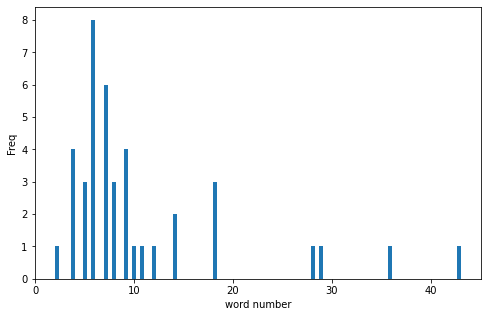

Shape of data tensor: (41, 10)
Shape of label tensor: (41, 3)
x shape:  (41, 10)
y shape:  (41, 3)
[  91  243  454  168 2980 8171   88 1317  231 1540]
[0. 1. 0.]


In [35]:
with open('dataset/tokenizer.pickle', 'rb') as handle: 
    tokenizer = pickle.load(handle)
x, y = load_and_prec_test(tokenizer)

In [36]:
from sklearn.metrics import confusion_matrix

data_num = len(x) ## 等于所有数据 / batchsize，所以所有数据需要能够整除
test_pred = model.predict(x)    #验证集正确
test_true = y
test_pred_flat = np.zeros(data_num)    #验证集预测
test_true_flat = np.zeros(data_num)    #验证集正确
for data_count in range(data_num):
    test_pred_flat[data_count] = np.argmax(test_pred[data_count])
    test_true_flat[data_count] = np.argmax(test_true[data_count])
f=open("dataset/predict/6600_pred.txt","w")
outstr=''
for item in test_pred_flat:
    outstr+=str(item)+'\n'
f.write(outstr)
f.close()

f=open("dataset/predict/6600_true.txt","w")
outstr=''
for item in test_true_flat:
    outstr+=str(item)+'\n'
f.write(outstr)
f.close()

In [37]:
count1=0
count2=0
count4=0
for item in test_pred_flat:
    if item == 0:count1+=1
    elif item == 1:count2+=1
    else:count4+=1
print(count1)
print(count2)
print(count4)

count1=0
count2=0
count4=0
for item in test_true_flat:
    if item == 0:count1+=1
    elif item == 1:count2+=1
    else:count4+=1
print(count1)
print(count2)
print(count4)

8
14
19
6
15
20
